# Calculate the intregrals and frequency distributions of O2 consumption by NOB in AMZ

imports

In [1]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
netCDF4 version = 1.6.5
dask version = 2023.3.0
pandas version = 2.2.3
scipy version = 1.14.1
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg'

Load model output

In [2]:
data = xr.open_mfdataset(['2hets_def/avg_2050_D000-D090.nc','2hets_def/avg_2050_D091-D180.nc','2hets_def/avg_2050_D181-D270.nc', '2hets_def/avg_2050_D271-D365.nc'])
norm_o2cons = data["O2_CONSUMPTION"]
norm_nitrox = data["NITROX"]
norm_ammox = data["AMMOX"]
#norm_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
norm_hz = data["Hz"]
norm_zr = data["z_r"]
norm_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_het2p0/avg_2050_D000-D090.nc','2hets_het2p0/avg_2050_D091-D180.nc','2hets_het2p0/avg_2050_D181-D270.nc', '2hets_het2p0/avg_2050_D271-D365.nc'])
het2_o2cons = data["O2_CONSUMPTION"]
het2_nitrox = data["NITROX"]
het2_ammox = data["AMMOX"]
#het2_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
het2_hz = data["Hz"]
het2_zr = data["z_r"]
het2_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_nob1p0/avg_2050_D000-D090.nc','2hets_nob1p0/avg_2050_D091-D180.nc','2hets_nob1p0/avg_2050_D181-D270.nc', '2hets_nob1p0/avg_2050_D271-D365.nc'])
nob1_o2cons = data["O2_CONSUMPTION"]
nob1_nitrox = data["NITROX"]
nob1_ammox = data["AMMOX"]
#nob1_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
nob1_hz = data["Hz"]
nob1_zr = data["z_r"]
nob1_o2 = data["O2"]

data = xr.open_mfdataset(['2hets_allmu/avg_2050_D000-D090.nc','2hets_allmu/avg_2050_D091-D180.nc','2hets_allmu/avg_2050_D181-D270.nc', '2hets_allmu/avg_2050_D271-D365.nc'])
all_o2cons = data["O2_CONSUMPTION"]
all_nitrox = data["NITROX"]
all_ammox = data["AMMOX"]
#all_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
all_hz = data["Hz"]
all_zr = data["z_r"]
all_o2 = data["O2"]



Get Coordinates

In [3]:
fname = '/home/pbuchanan/peru_chile_0p1_files/peru_chile_0p1_grd.nc' 
data = xr.open_dataset(fname)
data = data.rename_dims({"eta_rho":"y_c", "xi_rho":"x_c"})
lon_rho = data.coords['lon_rho']
lat_rho = data.coords['lat_rho']

pn = data['pm']
pm = data['pn']
area = 1.0/(pn*pm)



Define a new dataset manually with its coordinates and the variables we want

In [4]:

chunky = {'time':1, 'z_c':1, 'y_c':502, 'x_c':402}
ds = xr.Dataset(
    {"lon_rho": ( ("y_c", "x_c"), lon_rho.values),
     "lat_rho": ( ("y_c", "x_c"), lat_rho.values),
     "area":    ( ("y_c", "x_c"), area.values),
     "norm_Hz": ( ("time", "z_c", "y_c", "x_c"), norm_hz.values),
     "het2_Hz": ( ("time", "z_c", "y_c", "x_c"), het2_hz.values),
     "nob1_Hz": ( ("time", "z_c", "y_c", "x_c"), nob1_hz.values),
     "all_Hz": ( ("time", "z_c", "y_c", "x_c"), all_hz.values),
     },
    coords={"x_c": (["x_c"], np.arange(1,403)),
            "y_c": (["y_c"], np.arange(1,503)),
            "z_c": (["z_c"], np.arange(1,43)),
            "time":(["time"],np.arange(1,366))}).chunk(chunks=chunky)

# check size of the arrays in Gb and their chunks in Mb
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)



Total size of array in Gb 49.500917256
Total size of chunk in Mb 138.04151199999998


In [5]:
### assign other variables to the dataset
ds = ds.assign({"norm_zr": ( ("time", "z_c", "y_c", "x_c"), norm_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"norm_O2": ( ("time", "z_c", "y_c", "x_c"),  norm_o2.values)}).chunk(chunks=chunky)
print("Added O2")
#ds = ds.assign({"norm_NOB": ( ("time", "z_c", "y_c", "x_c"), norm_nob.values)}).chunk(chunks=chunky)
#print("Added NOB")
ds = ds.assign({"norm_ammox": ( ("time", "z_c", "y_c", "x_c"), norm_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"norm_nitrox": ( ("time", "z_c", "y_c", "x_c"), norm_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"norm_o2cons": ( ("time", "z_c", "y_c", "x_c"), norm_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"het2_zr": ( ("time", "z_c", "y_c", "x_c"), het2_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"het2_O2": ( ("time", "z_c", "y_c", "x_c"),  het2_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"het2_ammox": ( ("time", "z_c", "y_c", "x_c"), het2_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"het2_nitrox": ( ("time", "z_c", "y_c", "x_c"), het2_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"het2_o2cons": ( ("time", "z_c", "y_c", "x_c"), het2_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"nob1_zr": ( ("time", "z_c", "y_c", "x_c"), nob1_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"nob1_O2": ( ("time", "z_c", "y_c", "x_c"),  nob1_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"nob1_ammox": ( ("time", "z_c", "y_c", "x_c"), nob1_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"nob1_nitrox": ( ("time", "z_c", "y_c", "x_c"), nob1_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"nob1_o2cons": ( ("time", "z_c", "y_c", "x_c"), nob1_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds = ds.assign({"all_zr": ( ("time", "z_c", "y_c", "x_c"), all_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"all_O2": ( ("time", "z_c", "y_c", "x_c"),  all_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"all_ammox": ( ("time", "z_c", "y_c", "x_c"), all_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"all_nitrox": ( ("time", "z_c", "y_c", "x_c"), all_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"all_o2cons": ( ("time", "z_c", "y_c", "x_c"), all_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")


ds

Added z_rho
Added O2
Added ammox
Added nitrox
Added o2cons
Added z_rho
Added O2
Added ammox


KeyboardInterrupt: 

Check the size of the arrays in Gb and their chunks in Mb

In [ ]:
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


Calculate the rates of O2 consumption and other processes within the AMZ and over whole area

In [8]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['norm_nitrox'] * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'] * ds['norm_Hz'] * ds['area']
#no3red = ds['norm_no3red'] * ds['norm_Hz'] * ds['area']
#no2red = ds['norm_no2red'] * ds['norm_Hz'] * ds['area']
#anammox = ds['norm_anammox'] * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'] * ds['norm_Hz'] * ds['area']
#totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']) * ds['norm_Hz'] * ds['area']
#nobC = ds['norm_NOB'] * ds['norm_Hz'] * ds['area']
#aoaC = ds['norm_AOA'] * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
#no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
#no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
#anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
#totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
#nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
#aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
#Cnob_sum = nobC_sum / totalC_sum * 100
#Caoa_sum = aoaC_sum / totalC_sum * 100

print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean oxidation of NO2-->NO3 via anammox within All (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
#print("Annual mean reduction of NO2-->N2 within All (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean reduction of NO3-->NO2 within All (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean N loss via anammox within All (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)
#print(" ")
#print("Annual % contribution of NOB to microbial C biomass within All", Cnob_sum.mean().values)
#print("Annual % contribution of AOA to microbial C biomass within All", Caoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#no3red = ds['norm_no3red'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#no2red = ds['norm_no2red'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#anammox = ds['norm_anammox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#totalC = (ds['norm_AOA'] + ds['norm_NOB'] + ds['norm_AOX'] + ds['norm_NAR'] + ds['norm_NIO']).where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#nobC = ds['norm_NOB'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
#aoaC = ds['norm_AOA'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
#no3red_sum = no3red.sum(dim=["z_c","y_c","x_c"])
#no2red_sum = no2red.sum(dim=["z_c","y_c","x_c"])
#anammox_sum = anammox.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])
#totalC_sum = totalC.sum(dim=["z_c","y_c","x_c"])
#nobC_sum = nobC.sum(dim=["z_c","y_c","x_c"])
#aoaC_sum = aoaC.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
#Cnob_sum = nobC_sum / totalC_sum * 100
#Caoa_sum = aoaC_sum / totalC_sum * 100

print(" ")
print(" ")
print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean oxidation of NO2-->NO3 via anammox within AMZ (Tg NO2)", anammox_sum.mean().values*14*1e-3*1e-12*86400*365*(2.2/14.0))
#print("Annual mean reduction of NO2-->N2 within AMZ (Tg NO2)", no2red_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean reduction of NO3-->NO2 within AMZ (Tg NO3)", no3red_sum.mean().values*14*1e-3*1e-12*86400*365)
#print("Annual mean N loss via anammox within AMZ (Tg N)", anammox_sum.mean().values*14*2*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)
#print(" ")
#print("Annual % contribution of NOB to microbial C biomass within AMZ", Cnob_sum.mean().values)
#print("Annual % contribution of AOA to microbial C biomass within AMZ", Caoa_sum.mean().values)



 Facultative EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 277.186831515648
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 212.76935337369596
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 219.65078306304
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 7.280306016221008
Annual mean loss of O2 within All due to AOA (Tmol O2) 21.415097255144726
 
Annual % contribution of NOB to O2 consumption within All 2.652864
Annual % contribution of AOA to O2 consumption within All 7.797087
 
 
 Facultative EXPERIMENT 
 
Annual mean loss of O2 within AMZ (Tmol O2) 1.0291234334400001
Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2) 0.91989952236
Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2) 13.161360510144002
 
Annual mean loss of O2 within AMZ due to NOB (Tmol O2) 0.4362321443495827
Annual mean loss of O2 within AMZ due to AOA (Tmol O2) 0.09258728958818184
 
Annual % contribution of NOB to O2 consumption within AMZ 42.661415
Annual % contribution of

In [9]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['het2_nitrox'] * ds['het2_Hz'] * ds['area']
o2cons = ds['het2_o2cons'] * ds['het2_Hz'] * ds['area']
ammox = ds['het2_ammox'] * ds['het2_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']
ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz_threshold, other=0.0) * ds['het2_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" ")
print(" ")
print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)



 Facultative EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 295.77399046963194
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 240.486932109312
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 242.494454329344
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 8.037457504749584
Annual mean loss of O2 within All due to AOA (Tmol O2) 24.204853556456726
 
Annual % contribution of NOB to O2 consumption within All 2.7440715
Annual % contribution of AOA to O2 consumption within All 8.257949
 
 
 Facultative EXPERIMENT 
 
Annual mean loss of O2 within AMZ (Tmol O2) 1.1099129258879998
Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2) 1.1152963891440002
Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2) 11.302173038016
 
Annual mean loss of O2 within AMZ due to NOB (Tmol O2) 0.3746095380020719
Annual mean loss of O2 within AMZ due to AOA (Tmol O2) 0.1122538573489091
 
Annual % contribution of NOB to O2 consumption within AMZ 33.988483
Annual % contribution

In [10]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['nob1_nitrox'] * ds['nob1_Hz'] * ds['area']
o2cons = ds['nob1_o2cons'] * ds['nob1_Hz'] * ds['area']
ammox = ds['nob1_ammox'] * ds['nob1_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']
ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz_threshold, other=0.0) * ds['nob1_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" ")
print(" ")
print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)



 Facultative EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 293.82353377689594
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 239.38411869388798
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 223.05283628544
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 7.39306677307856
Annual mean loss of O2 within All due to AOA (Tmol O2) 24.093856102306912
 
Annual % contribution of NOB to O2 consumption within All 2.5455046
Annual % contribution of AOA to O2 consumption within All 8.272605
 
 
 Facultative EXPERIMENT 
 
Annual mean loss of O2 within AMZ (Tmol O2) 1.009261808352
Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2) 1.115359082712
Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2) 8.211213247103998
 
Annual mean loss of O2 within AMZ due to NOB (Tmol O2) 0.27215994575447483
Annual mean loss of O2 within AMZ due to AOA (Tmol O2) 0.11226016741581818
 
Annual % contribution of NOB to O2 consumption within AMZ 27.199663
Annual % contribution of 

In [11]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['all_nitrox'] * ds['all_Hz'] * ds['area']
o2cons = ds['all_o2cons'] * ds['all_Hz'] * ds['area']
ammox = ds['all_ammox'] * ds['all_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']
ammox = ds['all_ammox'].where(ds['all_O2'] < amz_threshold, other=0.0) * ds['all_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" ")
print(" ")
print(" Facultative EXPERIMENT ")
print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)



 Facultative EXPERIMENT 
 
Annual mean loss of O2 within All (Tmol O2) 305.853917331456
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 323.014131320832
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 290.08705969152
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 9.61491025185151
Annual mean loss of O2 within All due to AOA (Tmol O2) 32.511162568005815
 
Annual % contribution of NOB to O2 consumption within All 3.1702757
Annual % contribution of AOA to O2 consumption within All 10.684325
 
 
 Facultative EXPERIMENT 
 
Annual mean loss of O2 within AMZ (Tmol O2) 1.042581989088
Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2) 1.384198263504
Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2) 8.416455211584
 
Annual mean loss of O2 within AMZ due to NOB (Tmol O2) 0.2789626727374964
Annual mean loss of O2 within AMZ due to AOA (Tmol O2) 0.13931865639163638
 
Annual % contribution of NOB to O2 consumption within AMZ 26.98811
Annual % contribution of AOA to O

# INTEGRATED contribution of NOB to oxygen consumption at varying levels of O2

In [8]:
%%time

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200])

int_vol_mean = []
int_nitrox_mean = []
int_ammox_mean = []
int_o2cons_mean = []
int_o2nob_mean = []
int_o2aoa_mean = []
int_o2nob_std = []
int_o2aoa_std = []
int_o2nob_min = []
int_o2aoa_min = []
int_o2nob_max = []
int_o2aoa_max = []
int_o2nob_q01 = []
int_o2aoa_q01 = []
int_o2nob_q05 = []
int_o2aoa_q05 = []
int_o2nob_q12 = []
int_o2aoa_q12 = []
int_o2nob_q25 = []
int_o2aoa_q25 = []
int_o2nob_q50 = []
int_o2aoa_q50 = []
int_o2nob_q75 = []
int_o2aoa_q75 = []
int_o2nob_q88 = []
int_o2aoa_q88 = []
int_o2nob_q95 = []
int_o2aoa_q95 = []
int_o2nob_q99 = []
int_o2aoa_q99 = []


for ii,amz in enumerate(amz_threshold):
    print(amz)
    if ii == 0:
        vol = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
    else:
        vol = ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=0.0) * ds['norm_Hz'] * ds['area']
        #amzb = amz_threshold[ii-1]
        #vol = ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']
        #o2cons = ds['norm_o2cons'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #nitrox = ds['norm_nitrox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #ammox = ds['norm_ammox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['norm_Hz'] * ds['area']
        #volume = ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"])
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    
    int_vol_mean.append(vol_sum.mean().values)
    int_nitrox_mean.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_ammox_mean.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_o2cons_mean.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    int_o2nob_mean.append(o2nob_sum.mean().values)
    int_o2aoa_mean.append(o2aoa_sum.mean().values)
    int_o2nob_std.append(o2nob_sum.std().values)
    int_o2aoa_std.append(o2aoa_sum.std().values)
    int_o2nob_min.append(o2nob_sum.min().values)
    int_o2aoa_min.append(o2aoa_sum.min().values)
    int_o2nob_max.append(o2nob_sum.max().values)
    int_o2aoa_max.append(o2aoa_sum.max().values)
    int_o2nob_q01.append(o2nob_sum.quantile(0.01).values)
    int_o2aoa_q01.append(o2aoa_sum.quantile(0.01).values)
    int_o2nob_q05.append(o2nob_sum.quantile(0.05).values)
    int_o2aoa_q05.append(o2aoa_sum.quantile(0.05).values)
    int_o2nob_q12.append(o2nob_sum.quantile(0.12).values)
    int_o2aoa_q12.append(o2aoa_sum.quantile(0.12).values)
    int_o2nob_q25.append(o2nob_sum.quantile(0.25).values)
    int_o2aoa_q25.append(o2aoa_sum.quantile(0.25).values)
    int_o2nob_q50.append(o2nob_sum.quantile(0.50).values)
    int_o2aoa_q50.append(o2aoa_sum.quantile(0.50).values)
    int_o2nob_q75.append(o2nob_sum.quantile(0.75).values)
    int_o2aoa_q75.append(o2aoa_sum.quantile(0.75).values)
    int_o2nob_q88.append(o2nob_sum.quantile(0.88).values)
    int_o2aoa_q88.append(o2aoa_sum.quantile(0.88).values)
    int_o2nob_q95.append(o2nob_sum.quantile(0.95).values)
    int_o2aoa_q95.append(o2aoa_sum.quantile(0.95).values)
    int_o2nob_q99.append(o2nob_sum.quantile(0.99).values)
    int_o2aoa_q99.append(o2aoa_sum.quantile(0.99).values)
    

int_vol_mean = np.array(int_vol_mean)
int_nitrox_mean = np.array(int_nitrox_mean)
int_ammox_mean = np.array(int_ammox_mean)
int_o2cons_mean = np.array(int_o2cons_mean)
int_o2nob_mean = np.array(int_o2nob_mean)
int_o2aoa_mean = np.array(int_o2aoa_mean)
int_o2nob_std = np.array(int_o2nob_std)
int_o2aoa_std = np.array(int_o2aoa_std)
int_o2nob_min = np.array(int_o2nob_min)
int_o2aoa_min = np.array(int_o2aoa_min)
int_o2nob_max = np.array(int_o2nob_max)
int_o2aoa_max = np.array(int_o2aoa_max)
int_o2nob_q01 = np.array(int_o2nob_q01)
int_o2aoa_q01 = np.array(int_o2aoa_q01)
int_o2nob_q05 = np.array(int_o2nob_q05)
int_o2aoa_q05 = np.array(int_o2aoa_q05)
int_o2nob_q12 = np.array(int_o2nob_q12)
int_o2aoa_q12 = np.array(int_o2aoa_q12)
int_o2nob_q25 = np.array(int_o2nob_q25)
int_o2aoa_q25 = np.array(int_o2aoa_q25)
int_o2nob_q50 = np.array(int_o2nob_q50)
int_o2aoa_q50 = np.array(int_o2aoa_q50)
int_o2nob_q75 = np.array(int_o2nob_q75)
int_o2aoa_q75 = np.array(int_o2aoa_q75)
int_o2nob_q88 = np.array(int_o2nob_q88)
int_o2aoa_q88 = np.array(int_o2aoa_q88)
int_o2nob_q95 = np.array(int_o2nob_q95)
int_o2aoa_q95 = np.array(int_o2aoa_q95)
int_o2nob_q99 = np.array(int_o2nob_q99)
int_o2aoa_q99 = np.array(int_o2aoa_q99)


df = pd.DataFrame({
    "O2_threshold":amz_threshold,
    "int_vol_mean":int_vol_mean,
    "int_nitrox_mean":int_nitrox_mean,
    "int_ammox_mean":int_ammox_mean,
    "int_o2cons_mean":int_o2cons_mean,
    "int_o2nob_mean":int_o2nob_mean,
    "int_o2aoa_mean":int_o2aoa_mean,
    "int_o2nob_std":int_o2nob_std,
    "int_o2aoa_std":int_o2aoa_std,
    "int_o2nob_min":int_o2nob_min,
    "int_o2aoa_min":int_o2aoa_min,
    "int_o2nob_max":int_o2nob_max,
    "int_o2aoa_max":int_o2aoa_max,
    "int_o2nob_q01":int_o2nob_q01,
    "int_o2aoa_q01":int_o2aoa_q01,
    "int_o2nob_q05":int_o2nob_q05,
    "int_o2aoa_q05":int_o2aoa_q05,
    "int_o2nob_q12":int_o2nob_q12,
    "int_o2aoa_q12":int_o2aoa_q12,
    "int_o2nob_q25":int_o2nob_q25,
    "int_o2aoa_q25":int_o2aoa_q25,
    "int_o2nob_q50":int_o2nob_q50,
    "int_o2aoa_q50":int_o2aoa_q50,
    "int_o2nob_q75":int_o2nob_q75,
    "int_o2aoa_q75":int_o2aoa_q75,
    "int_o2nob_q88":int_o2nob_q88,
    "int_o2aoa_q88":int_o2aoa_q88,
    "int_o2nob_q95":int_o2nob_q95,
    "int_o2aoa_q95":int_o2aoa_q95,
    "int_o2nob_q99":int_o2nob_q99,
    "int_o2aoa_q99":int_o2aoa_q99,
})

df.to_excel('/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics.xlsx', index=False)




0.05
0.1
0.2
0.3
0.5
0.75
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
100.0
125.0
150.0
175.0
200.0
CPU times: user 55min 3s, sys: 4min 2s, total: 59min 6s
Wall time: 28min 50s


See if we can back out the integrated contribution of NOB to O2 consumption by weighting a calculation of the mean by the total O2 consumption rate

In [10]:
%%time

o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < 1.0, other=np.nan).compute()
nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < 1.0, other=np.nan).compute()

o2nob = nitrox * 12.9/27.8 / o2cons * 100

o2nob_unweighted_mean = o2nob.mean().values
o2nob_weighted_mean = o2nob.weighted(o2cons.fillna(0.0)).mean(skipna=True).values

print("Unweighted mean NOB contrib to O2 consumption beneath 1 µM =", o2nob_unweighted_mean)
print("Weighted mean NOB contrib to O2 consumption beneath 1 µM (by O2 consumption rate) =", o2nob_weighted_mean)


Unweighted mean NOB contrib to O2 consumption beneath 1 µM = 5.8411903
Weighted mean NOB contrib to O2 consumption beneath 1 µM (by O2 consumption rate) = 35.199978
CPU times: user 40.5 s, sys: 16.9 s, total: 57.4 s
Wall time: 42.9 s


In [9]:
%%time

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200])

int_vol_mean = []
int_nitrox_mean = []
int_ammox_mean = []
int_o2cons_mean = []
int_o2nob_mean = []
int_o2aoa_mean = []
int_o2nob_std = []
int_o2aoa_std = []
int_o2nob_min = []
int_o2aoa_min = []
int_o2nob_max = []
int_o2aoa_max = []
int_o2nob_q01 = []
int_o2aoa_q01 = []
int_o2nob_q05 = []
int_o2aoa_q05 = []
int_o2nob_q12 = []
int_o2aoa_q12 = []
int_o2nob_q25 = []
int_o2aoa_q25 = []
int_o2nob_q50 = []
int_o2aoa_q50 = []
int_o2nob_q75 = []
int_o2aoa_q75 = []
int_o2nob_q88 = []
int_o2aoa_q88 = []
int_o2nob_q95 = []
int_o2aoa_q95 = []
int_o2nob_q99 = []
int_o2aoa_q99 = []


for ii,amz in enumerate(amz_threshold):
    print(amz)
    if ii == 0:
        vol = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
    else:
        vol = ds['het2_Hz'].where(ds['het2_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['het2_o2cons'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        nitrox = ds['het2_nitrox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']
        ammox = ds['het2_ammox'].where(ds['het2_O2'] < amz, other=0.0) * ds['het2_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"])
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    
    int_vol_mean.append(vol_sum.mean().values)
    int_nitrox_mean.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_ammox_mean.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_o2cons_mean.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    int_o2nob_mean.append(o2nob_sum.mean().values)
    int_o2aoa_mean.append(o2aoa_sum.mean().values)
    int_o2nob_std.append(o2nob_sum.std().values)
    int_o2aoa_std.append(o2aoa_sum.std().values)
    int_o2nob_min.append(o2nob_sum.min().values)
    int_o2aoa_min.append(o2aoa_sum.min().values)
    int_o2nob_max.append(o2nob_sum.max().values)
    int_o2aoa_max.append(o2aoa_sum.max().values)
    int_o2nob_q01.append(o2nob_sum.quantile(0.01).values)
    int_o2aoa_q01.append(o2aoa_sum.quantile(0.01).values)
    int_o2nob_q05.append(o2nob_sum.quantile(0.05).values)
    int_o2aoa_q05.append(o2aoa_sum.quantile(0.05).values)
    int_o2nob_q12.append(o2nob_sum.quantile(0.12).values)
    int_o2aoa_q12.append(o2aoa_sum.quantile(0.12).values)
    int_o2nob_q25.append(o2nob_sum.quantile(0.25).values)
    int_o2aoa_q25.append(o2aoa_sum.quantile(0.25).values)
    int_o2nob_q50.append(o2nob_sum.quantile(0.50).values)
    int_o2aoa_q50.append(o2aoa_sum.quantile(0.50).values)
    int_o2nob_q75.append(o2nob_sum.quantile(0.75).values)
    int_o2aoa_q75.append(o2aoa_sum.quantile(0.75).values)
    int_o2nob_q88.append(o2nob_sum.quantile(0.88).values)
    int_o2aoa_q88.append(o2aoa_sum.quantile(0.88).values)
    int_o2nob_q95.append(o2nob_sum.quantile(0.95).values)
    int_o2aoa_q95.append(o2aoa_sum.quantile(0.95).values)
    int_o2nob_q99.append(o2nob_sum.quantile(0.99).values)
    int_o2aoa_q99.append(o2aoa_sum.quantile(0.99).values)
    

int_vol_mean = np.array(int_vol_mean)
int_nitrox_mean = np.array(int_nitrox_mean)
int_ammox_mean = np.array(int_ammox_mean)
int_o2cons_mean = np.array(int_o2cons_mean)
int_o2nob_mean = np.array(int_o2nob_mean)
int_o2aoa_mean = np.array(int_o2aoa_mean)
int_o2nob_std = np.array(int_o2nob_std)
int_o2aoa_std = np.array(int_o2aoa_std)
int_o2nob_min = np.array(int_o2nob_min)
int_o2aoa_min = np.array(int_o2aoa_min)
int_o2nob_max = np.array(int_o2nob_max)
int_o2aoa_max = np.array(int_o2aoa_max)
int_o2nob_q01 = np.array(int_o2nob_q01)
int_o2aoa_q01 = np.array(int_o2aoa_q01)
int_o2nob_q05 = np.array(int_o2nob_q05)
int_o2aoa_q05 = np.array(int_o2aoa_q05)
int_o2nob_q12 = np.array(int_o2nob_q12)
int_o2aoa_q12 = np.array(int_o2aoa_q12)
int_o2nob_q25 = np.array(int_o2nob_q25)
int_o2aoa_q25 = np.array(int_o2aoa_q25)
int_o2nob_q50 = np.array(int_o2nob_q50)
int_o2aoa_q50 = np.array(int_o2aoa_q50)
int_o2nob_q75 = np.array(int_o2nob_q75)
int_o2aoa_q75 = np.array(int_o2aoa_q75)
int_o2nob_q88 = np.array(int_o2nob_q88)
int_o2aoa_q88 = np.array(int_o2aoa_q88)
int_o2nob_q95 = np.array(int_o2nob_q95)
int_o2aoa_q95 = np.array(int_o2aoa_q95)
int_o2nob_q99 = np.array(int_o2nob_q99)
int_o2aoa_q99 = np.array(int_o2aoa_q99)



df = pd.DataFrame({
    "O2_threshold":amz_threshold,
    "int_vol_mean":int_vol_mean,
    "int_nitrox_mean":int_nitrox_mean,
    "int_ammox_mean":int_ammox_mean,
    "int_o2cons_mean":int_o2cons_mean,
    "int_o2nob_mean":int_o2nob_mean,
    "int_o2aoa_mean":int_o2aoa_mean,
    "int_o2nob_std":int_o2nob_std,
    "int_o2aoa_std":int_o2aoa_std,
    "int_o2nob_min":int_o2nob_min,
    "int_o2aoa_min":int_o2aoa_min,
    "int_o2nob_max":int_o2nob_max,
    "int_o2aoa_max":int_o2aoa_max,
    "int_o2nob_q01":int_o2nob_q01,
    "int_o2aoa_q01":int_o2aoa_q01,
    "int_o2nob_q05":int_o2nob_q05,
    "int_o2aoa_q05":int_o2aoa_q05,
    "int_o2nob_q12":int_o2nob_q12,
    "int_o2aoa_q12":int_o2aoa_q12,
    "int_o2nob_q25":int_o2nob_q25,
    "int_o2aoa_q25":int_o2aoa_q25,
    "int_o2nob_q50":int_o2nob_q50,
    "int_o2aoa_q50":int_o2aoa_q50,
    "int_o2nob_q75":int_o2nob_q75,
    "int_o2aoa_q75":int_o2aoa_q75,
    "int_o2nob_q88":int_o2nob_q88,
    "int_o2aoa_q88":int_o2aoa_q88,
    "int_o2nob_q95":int_o2nob_q95,
    "int_o2aoa_q95":int_o2aoa_q95,
    "int_o2nob_q99":int_o2nob_q99,
    "int_o2aoa_q99":int_o2aoa_q99,
})

df.to_excel('/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_het2p0.xlsx', index=False)



0.05
0.1
0.2
0.3
0.5
0.75
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
100.0
125.0
150.0
175.0
200.0
CPU times: user 56min 9s, sys: 5min 25s, total: 1h 1min 34s
Wall time: 29min 50s


In [7]:
%%time

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200])

int_vol_mean = []
int_nitrox_mean = []
int_ammox_mean = []
int_o2cons_mean = []
int_o2nob_mean = []
int_o2aoa_mean = []
int_o2nob_std = []
int_o2aoa_std = []
int_o2nob_min = []
int_o2aoa_min = []
int_o2nob_max = []
int_o2aoa_max = []
int_o2nob_q01 = []
int_o2aoa_q01 = []
int_o2nob_q05 = []
int_o2aoa_q05 = []
int_o2nob_q12 = []
int_o2aoa_q12 = []
int_o2nob_q25 = []
int_o2aoa_q25 = []
int_o2nob_q50 = []
int_o2aoa_q50 = []
int_o2nob_q75 = []
int_o2aoa_q75 = []
int_o2nob_q88 = []
int_o2aoa_q88 = []
int_o2nob_q95 = []
int_o2aoa_q95 = []
int_o2nob_q99 = []
int_o2aoa_q99 = []


for ii,amz in enumerate(amz_threshold):
    print(amz)
    if ii == 0:
        vol = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
    else:
        vol = ds['nob1_Hz'].where(ds['nob1_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['nob1_o2cons'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        nitrox = ds['nob1_nitrox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']
        ammox = ds['nob1_ammox'].where(ds['nob1_O2'] < amz, other=0.0) * ds['nob1_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"])
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    
    int_vol_mean.append(vol_sum.mean().values)
    int_nitrox_mean.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_ammox_mean.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_o2cons_mean.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    int_o2nob_mean.append(o2nob_sum.mean().values)
    int_o2aoa_mean.append(o2aoa_sum.mean().values)
    int_o2nob_std.append(o2nob_sum.std().values)
    int_o2aoa_std.append(o2aoa_sum.std().values)
    int_o2nob_min.append(o2nob_sum.min().values)
    int_o2aoa_min.append(o2aoa_sum.min().values)
    int_o2nob_max.append(o2nob_sum.max().values)
    int_o2aoa_max.append(o2aoa_sum.max().values)
    int_o2nob_q01.append(o2nob_sum.quantile(0.01).values)
    int_o2aoa_q01.append(o2aoa_sum.quantile(0.01).values)
    int_o2nob_q05.append(o2nob_sum.quantile(0.05).values)
    int_o2aoa_q05.append(o2aoa_sum.quantile(0.05).values)
    int_o2nob_q12.append(o2nob_sum.quantile(0.12).values)
    int_o2aoa_q12.append(o2aoa_sum.quantile(0.12).values)
    int_o2nob_q25.append(o2nob_sum.quantile(0.25).values)
    int_o2aoa_q25.append(o2aoa_sum.quantile(0.25).values)
    int_o2nob_q50.append(o2nob_sum.quantile(0.50).values)
    int_o2aoa_q50.append(o2aoa_sum.quantile(0.50).values)
    int_o2nob_q75.append(o2nob_sum.quantile(0.75).values)
    int_o2aoa_q75.append(o2aoa_sum.quantile(0.75).values)
    int_o2nob_q88.append(o2nob_sum.quantile(0.88).values)
    int_o2aoa_q88.append(o2aoa_sum.quantile(0.88).values)
    int_o2nob_q95.append(o2nob_sum.quantile(0.95).values)
    int_o2aoa_q95.append(o2aoa_sum.quantile(0.95).values)
    int_o2nob_q99.append(o2nob_sum.quantile(0.99).values)
    int_o2aoa_q99.append(o2aoa_sum.quantile(0.99).values)
    

int_vol_mean = np.array(int_vol_mean)
int_nitrox_mean = np.array(int_nitrox_mean)
int_ammox_mean = np.array(int_ammox_mean)
int_o2cons_mean = np.array(int_o2cons_mean)
int_o2nob_mean = np.array(int_o2nob_mean)
int_o2aoa_mean = np.array(int_o2aoa_mean)
int_o2nob_std = np.array(int_o2nob_std)
int_o2aoa_std = np.array(int_o2aoa_std)
int_o2nob_min = np.array(int_o2nob_min)
int_o2aoa_min = np.array(int_o2aoa_min)
int_o2nob_max = np.array(int_o2nob_max)
int_o2aoa_max = np.array(int_o2aoa_max)
int_o2nob_q01 = np.array(int_o2nob_q01)
int_o2aoa_q01 = np.array(int_o2aoa_q01)
int_o2nob_q05 = np.array(int_o2nob_q05)
int_o2aoa_q05 = np.array(int_o2aoa_q05)
int_o2nob_q12 = np.array(int_o2nob_q12)
int_o2aoa_q12 = np.array(int_o2aoa_q12)
int_o2nob_q25 = np.array(int_o2nob_q25)
int_o2aoa_q25 = np.array(int_o2aoa_q25)
int_o2nob_q50 = np.array(int_o2nob_q50)
int_o2aoa_q50 = np.array(int_o2aoa_q50)
int_o2nob_q75 = np.array(int_o2nob_q75)
int_o2aoa_q75 = np.array(int_o2aoa_q75)
int_o2nob_q88 = np.array(int_o2nob_q88)
int_o2aoa_q88 = np.array(int_o2aoa_q88)
int_o2nob_q95 = np.array(int_o2nob_q95)
int_o2aoa_q95 = np.array(int_o2aoa_q95)
int_o2nob_q99 = np.array(int_o2nob_q99)
int_o2aoa_q99 = np.array(int_o2aoa_q99)



df = pd.DataFrame({
    "O2_threshold":amz_threshold,
    "int_vol_mean":int_vol_mean,
    "int_nitrox_mean":int_nitrox_mean,
    "int_ammox_mean":int_ammox_mean,
    "int_o2cons_mean":int_o2cons_mean,
    "int_o2nob_mean":int_o2nob_mean,
    "int_o2aoa_mean":int_o2aoa_mean,
    "int_o2nob_std":int_o2nob_std,
    "int_o2aoa_std":int_o2aoa_std,
    "int_o2nob_min":int_o2nob_min,
    "int_o2aoa_min":int_o2aoa_min,
    "int_o2nob_max":int_o2nob_max,
    "int_o2aoa_max":int_o2aoa_max,
    "int_o2nob_q01":int_o2nob_q01,
    "int_o2aoa_q01":int_o2aoa_q01,
    "int_o2nob_q05":int_o2nob_q05,
    "int_o2aoa_q05":int_o2aoa_q05,
    "int_o2nob_q12":int_o2nob_q12,
    "int_o2aoa_q12":int_o2aoa_q12,
    "int_o2nob_q25":int_o2nob_q25,
    "int_o2aoa_q25":int_o2aoa_q25,
    "int_o2nob_q50":int_o2nob_q50,
    "int_o2aoa_q50":int_o2aoa_q50,
    "int_o2nob_q75":int_o2nob_q75,
    "int_o2aoa_q75":int_o2aoa_q75,
    "int_o2nob_q88":int_o2nob_q88,
    "int_o2aoa_q88":int_o2aoa_q88,
    "int_o2nob_q95":int_o2nob_q95,
    "int_o2aoa_q95":int_o2aoa_q95,
    "int_o2nob_q99":int_o2nob_q99,
    "int_o2aoa_q99":int_o2aoa_q99,
})

df.to_excel('/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_nob1p0.xlsx', index=False)




0.05
0.1
0.2
0.3
0.5
0.75
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
100.0
125.0
150.0
175.0
200.0
CPU times: user 52min 54s, sys: 3min 51s, total: 56min 46s
Wall time: 27min 40s


In [9]:
%%time

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200])

int_vol_mean = []
int_nitrox_mean = []
int_ammox_mean = []
int_o2cons_mean = []
int_o2nob_mean = []
int_o2aoa_mean = []
int_o2nob_std = []
int_o2aoa_std = []
int_o2nob_min = []
int_o2aoa_min = []
int_o2nob_max = []
int_o2aoa_max = []
int_o2nob_q01 = []
int_o2aoa_q01 = []
int_o2nob_q05 = []
int_o2aoa_q05 = []
int_o2nob_q12 = []
int_o2aoa_q12 = []
int_o2nob_q25 = []
int_o2aoa_q25 = []
int_o2nob_q50 = []
int_o2aoa_q50 = []
int_o2nob_q75 = []
int_o2aoa_q75 = []
int_o2nob_q88 = []
int_o2aoa_q88 = []
int_o2nob_q95 = []
int_o2aoa_q95 = []
int_o2nob_q99 = []
int_o2aoa_q99 = []


for ii,amz in enumerate(amz_threshold):
    print(amz)
    if ii == 0:
        vol = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        ammox = ds['all_ammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
    else:
        vol = ds['all_Hz'].where(ds['all_O2'] < amz, other=0.0) * ds['area']
        o2cons = ds['all_o2cons'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        nitrox = ds['all_nitrox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']
        ammox = ds['all_ammox'].where(ds['all_O2'] < amz, other=0.0) * ds['all_Hz'] * ds['area']

    vol_sum = vol.sum(dim=["z_c","y_c","x_c"])
    o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"]).compute()
    nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"]).compute()
    ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"]).compute()
    
    o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
    o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100
    
    int_vol_mean.append(vol_sum.mean().values)
    int_nitrox_mean.append(nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_ammox_mean.append(ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
    int_o2cons_mean.append(o2cons_sum.mean().values*1e-3*1e-12*86400*365)
    int_o2nob_mean.append(o2nob_sum.mean().values)
    int_o2aoa_mean.append(o2aoa_sum.mean().values)
    int_o2nob_std.append(o2nob_sum.std().values)
    int_o2aoa_std.append(o2aoa_sum.std().values)
    int_o2nob_min.append(o2nob_sum.min().values)
    int_o2aoa_min.append(o2aoa_sum.min().values)
    int_o2nob_max.append(o2nob_sum.max().values)
    int_o2aoa_max.append(o2aoa_sum.max().values)
    int_o2nob_q01.append(o2nob_sum.quantile(0.01).values)
    int_o2aoa_q01.append(o2aoa_sum.quantile(0.01).values)
    int_o2nob_q05.append(o2nob_sum.quantile(0.05).values)
    int_o2aoa_q05.append(o2aoa_sum.quantile(0.05).values)
    int_o2nob_q12.append(o2nob_sum.quantile(0.12).values)
    int_o2aoa_q12.append(o2aoa_sum.quantile(0.12).values)
    int_o2nob_q25.append(o2nob_sum.quantile(0.25).values)
    int_o2aoa_q25.append(o2aoa_sum.quantile(0.25).values)
    int_o2nob_q50.append(o2nob_sum.quantile(0.50).values)
    int_o2aoa_q50.append(o2aoa_sum.quantile(0.50).values)
    int_o2nob_q75.append(o2nob_sum.quantile(0.75).values)
    int_o2aoa_q75.append(o2aoa_sum.quantile(0.75).values)
    int_o2nob_q88.append(o2nob_sum.quantile(0.88).values)
    int_o2aoa_q88.append(o2aoa_sum.quantile(0.88).values)
    int_o2nob_q95.append(o2nob_sum.quantile(0.95).values)
    int_o2aoa_q95.append(o2aoa_sum.quantile(0.95).values)
    int_o2nob_q99.append(o2nob_sum.quantile(0.99).values)
    int_o2aoa_q99.append(o2aoa_sum.quantile(0.99).values)
    

int_vol_mean = np.array(int_vol_mean)
int_nitrox_mean = np.array(int_nitrox_mean)
int_ammox_mean = np.array(int_ammox_mean)
int_o2cons_mean = np.array(int_o2cons_mean)
int_o2nob_mean = np.array(int_o2nob_mean)
int_o2aoa_mean = np.array(int_o2aoa_mean)
int_o2nob_std = np.array(int_o2nob_std)
int_o2aoa_std = np.array(int_o2aoa_std)
int_o2nob_min = np.array(int_o2nob_min)
int_o2aoa_min = np.array(int_o2aoa_min)
int_o2nob_max = np.array(int_o2nob_max)
int_o2aoa_max = np.array(int_o2aoa_max)
int_o2nob_q01 = np.array(int_o2nob_q01)
int_o2aoa_q01 = np.array(int_o2aoa_q01)
int_o2nob_q05 = np.array(int_o2nob_q05)
int_o2aoa_q05 = np.array(int_o2aoa_q05)
int_o2nob_q12 = np.array(int_o2nob_q12)
int_o2aoa_q12 = np.array(int_o2aoa_q12)
int_o2nob_q25 = np.array(int_o2nob_q25)
int_o2aoa_q25 = np.array(int_o2aoa_q25)
int_o2nob_q50 = np.array(int_o2nob_q50)
int_o2aoa_q50 = np.array(int_o2aoa_q50)
int_o2nob_q75 = np.array(int_o2nob_q75)
int_o2aoa_q75 = np.array(int_o2aoa_q75)
int_o2nob_q88 = np.array(int_o2nob_q88)
int_o2aoa_q88 = np.array(int_o2aoa_q88)
int_o2nob_q95 = np.array(int_o2nob_q95)
int_o2aoa_q95 = np.array(int_o2aoa_q95)
int_o2nob_q99 = np.array(int_o2nob_q99)
int_o2aoa_q99 = np.array(int_o2aoa_q99)



df = pd.DataFrame({
    "O2_threshold":amz_threshold,
    "int_vol_mean":int_vol_mean,
    "int_nitrox_mean":int_nitrox_mean,
    "int_ammox_mean":int_ammox_mean,
    "int_o2cons_mean":int_o2cons_mean,
    "int_o2nob_mean":int_o2nob_mean,
    "int_o2aoa_mean":int_o2aoa_mean,
    "int_o2nob_std":int_o2nob_std,
    "int_o2aoa_std":int_o2aoa_std,
    "int_o2nob_min":int_o2nob_min,
    "int_o2aoa_min":int_o2aoa_min,
    "int_o2nob_max":int_o2nob_max,
    "int_o2aoa_max":int_o2aoa_max,
    "int_o2nob_q01":int_o2nob_q01,
    "int_o2aoa_q01":int_o2aoa_q01,
    "int_o2nob_q05":int_o2nob_q05,
    "int_o2aoa_q05":int_o2aoa_q05,
    "int_o2nob_q12":int_o2nob_q12,
    "int_o2aoa_q12":int_o2aoa_q12,
    "int_o2nob_q25":int_o2nob_q25,
    "int_o2aoa_q25":int_o2aoa_q25,
    "int_o2nob_q50":int_o2nob_q50,
    "int_o2aoa_q50":int_o2aoa_q50,
    "int_o2nob_q75":int_o2nob_q75,
    "int_o2aoa_q75":int_o2aoa_q75,
    "int_o2nob_q88":int_o2nob_q88,
    "int_o2aoa_q88":int_o2aoa_q88,
    "int_o2nob_q95":int_o2nob_q95,
    "int_o2aoa_q95":int_o2aoa_q95,
    "int_o2nob_q99":int_o2nob_q99,
    "int_o2aoa_q99":int_o2aoa_q99,
})

df.to_excel('/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_allmu.xlsx', index=False)




0.05
0.1
0.2
0.3
0.5
0.75
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
100.0
125.0
150.0
175.0
200.0
CPU times: user 53min 35s, sys: 3min 43s, total: 57min 18s
Wall time: 29min 34s


# make figure of how nitrite oxidation, its contribution to O2 consumption, and its effect on anammox, AOA and denitrification are against oxygen

In [15]:
## read in the model data in case you don't want to wait for the above calculation to finish


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics.xlsx", engine='openpyxl')

amz_threshold = dat['O2_threshold']
int_vol_mean = dat['int_vol_mean']
int_nitrox_mean = dat['int_nitrox_mean']
int_ammox_mean = dat['int_ammox_mean']
int_o2cons_mean = dat['int_o2cons_mean']
int_o2nob_mean = dat['int_o2nob_mean']
int_o2aoa_mean = dat['int_o2aoa_mean']
int_o2nob_std = dat['int_o2nob_std']
int_o2nob_min = dat['int_o2nob_min']
int_o2aoa_min = dat['int_o2aoa_min']
int_o2nob_max = dat['int_o2nob_max']
int_o2aoa_max = dat['int_o2aoa_max']
int_o2nob_q01 = dat['int_o2nob_q01']
int_o2nob_q99 = dat['int_o2nob_q99']
int_o2aoa_q01 = dat['int_o2aoa_q01']
int_o2aoa_q99 = dat['int_o2aoa_q99']
int_o2nob_q50 = dat['int_o2nob_q50']
int_o2aoa_q50 = dat['int_o2aoa_q50']
int_o2nob_q25 = dat['int_o2nob_q25']
int_o2aoa_q25 = dat['int_o2aoa_q25']
int_o2nob_q75 = dat['int_o2nob_q75']
int_o2aoa_q75 = dat['int_o2aoa_q75']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_het2p0.xlsx", engine='openpyxl')

het2_vol_mean = dat['int_vol_mean']
het2_nitrox_mean = dat['int_nitrox_mean']
het2_ammox_mean = dat['int_ammox_mean']
het2_o2cons_mean = dat['int_o2cons_mean']
het2_o2nob_mean = dat['int_o2nob_mean']
het2_o2aoa_mean = dat['int_o2aoa_mean']
het2_o2nob_min = dat['int_o2nob_min']
het2_o2aoa_min = dat['int_o2aoa_min']
het2_o2nob_max = dat['int_o2nob_max']
het2_o2aoa_max = dat['int_o2aoa_max']
het2_o2nob_std = dat['int_o2nob_std']
het2_o2nob_q01 = dat['int_o2nob_q01']
het2_o2nob_q99 = dat['int_o2nob_q99']
het2_o2aoa_q01 = dat['int_o2aoa_q01']
het2_o2aoa_q99 = dat['int_o2aoa_q99']
het2_o2nob_q50 = dat['int_o2nob_q50']
het2_o2aoa_q50 = dat['int_o2aoa_q50']
het2_o2nob_q25 = dat['int_o2nob_q25']
het2_o2aoa_q25 = dat['int_o2aoa_q25']
het2_o2nob_q75 = dat['int_o2nob_q75']
het2_o2aoa_q75 = dat['int_o2aoa_q75']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_nob1p0.xlsx", engine='openpyxl')

nob1_vol_mean = dat['int_vol_mean']
nob1_nitrox_mean = dat['int_nitrox_mean']
nob1_ammox_mean = dat['int_ammox_mean']
nob1_o2cons_mean = dat['int_o2cons_mean']
nob1_o2nob_mean = dat['int_o2nob_mean']
nob1_o2aoa_mean = dat['int_o2aoa_mean']
nob1_o2nob_min = dat['int_o2nob_min']
nob1_o2aoa_min = dat['int_o2aoa_min']
nob1_o2nob_max = dat['int_o2nob_max']
nob1_o2aoa_max = dat['int_o2aoa_max']
nob1_o2nob_std = dat['int_o2nob_std']
nob1_o2nob_q01 = dat['int_o2nob_q01']
nob1_o2nob_q99 = dat['int_o2nob_q99']
nob1_o2aoa_q01 = dat['int_o2aoa_q01']
nob1_o2aoa_q99 = dat['int_o2aoa_q99']
nob1_o2nob_q50 = dat['int_o2nob_q50']
nob1_o2aoa_q50 = dat['int_o2aoa_q50']
nob1_o2nob_q25 = dat['int_o2nob_q25']
nob1_o2aoa_q25 = dat['int_o2aoa_q25']
nob1_o2nob_q75 = dat['int_o2nob_q75']
nob1_o2aoa_q75 = dat['int_o2aoa_q75']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_allmu.xlsx", engine='openpyxl')

all_vol_mean = dat['int_vol_mean']
all_nitrox_mean = dat['int_nitrox_mean']
all_ammox_mean = dat['int_ammox_mean']
all_o2cons_mean = dat['int_o2cons_mean']
all_o2nob_mean = dat['int_o2nob_mean']
all_o2aoa_mean = dat['int_o2aoa_mean']
all_o2nob_min = dat['int_o2nob_min']
all_o2aoa_min = dat['int_o2aoa_min']
all_o2nob_max = dat['int_o2nob_max']
all_o2aoa_max = dat['int_o2aoa_max']
all_o2nob_std = dat['int_o2nob_std']
all_o2nob_q01 = dat['int_o2nob_q01']
all_o2nob_q99 = dat['int_o2nob_q99']
all_o2aoa_q01 = dat['int_o2aoa_q01']
all_o2aoa_q99 = dat['int_o2aoa_q99']
all_o2nob_q50 = dat['int_o2nob_q50']
all_o2aoa_q50 = dat['int_o2aoa_q50']
all_o2nob_q25 = dat['int_o2nob_q25']
all_o2aoa_q25 = dat['int_o2aoa_q25']
all_o2nob_q75 = dat['int_o2nob_q75']
all_o2aoa_q75 = dat['int_o2aoa_q75']

dat


,O2_threshold,int_vol_mean,int_nitrox_mean,int_ammox_mean,int_o2cons_mean,int_o2nob_mean,int_o2aoa_mean,int_o2nob_std,int_o2aoa_std,int_o2nob_min,...,int_o2nob_q50,int_o2aoa_q50,int_o2nob_q75,int_o2aoa_q75,int_o2nob_q88,int_o2aoa_q88,int_o2nob_q95,int_o2aoa_q95,int_o2nob_q99,int_o2aoa_q99
0,0.05,462163579764736,0.978650,0.273070,0.285973,11.487037,9.575030,1.471118,1.427644,9.207972,...,11.341927,9.346715,12.524016,10.874675,13.467166,11.693422,14.331622,11.984995,14.954159,12.290282
1,0.10,468726994436096,1.511845,0.366590,0.339568,14.962375,10.820595,1.536509,1.239477,13.015018,...,14.390670,10.596271,15.619130,11.930364,17.388258,12.627418,18.268967,12.920031,18.664595,13.169208
2,0.20,480104295694336,2.709676,0.527960,0.444621,20.469769,11.890034,1.843302,1.105112,18.057043,...,19.946783,11.532701,20.867746,12.924716,23.606006,13.441645,24.469757,13.751921,24.909612,14.016617
3,0.30,490232935874560,3.790351,0.666728,0.540056,23.547678,12.356110,2.009881,1.056329,20.824953,...,23.033146,11.935434,24.226709,13.366771,27.042495,13.847265,27.826434,14.088669,28.121131,14.386569
4,0.50,508616335425536,5.537073,0.904962,0.706899,26.237291,12.809065,2.077402,1.012370,23.172955,...,26.043898,12.326326,27.050301,13.772591,29.738397,14.287192,30.448090,14.485257,30.753986,14.784685
5,0.75,529613558120448,7.168582,1.159359,0.885459,27.085114,13.101454,2.021147,0.975338,24.023176,...,27.148602,12.637880,27.901915,14.034767,30.491023,14.556911,31.101604,14.722392,31.376357,14.973637
6,1.00,549218473213952,8.416455,1.384198,1.042582,26.988110,13.286502,1.941630,0.938983,23.997358,...,27.117290,12.845980,27.682930,14.173074,30.206001,14.679567,30.792679,14.846138,31.130020,15.093072
7,1.50,585798642565120,10.243472,1.780861,1.317913,25.963619,13.526918,1.790313,0.871052,23.232498,...,26.008038,13.118484,26.723284,14.319415,28.874886,14.818789,29.451144,15.005536,29.753637,15.240079
8,2.00,620297094955008,11.551558,2.133871,1.561186,24.704805,13.687232,1.658802,0.809109,22.110758,...,24.680870,13.318470,25.514507,14.395195,27.366363,14.894813,27.956342,15.071114,28.254775,15.304232
9,2.50,653642080190464,12.558620,2.460000,1.784529,23.490076,13.808805,1.551499,0.754117,20.887697,...,23.437065,13.477908,24.251167,14.448245,25.993650,14.936173,26.570327,15.102274,26.825484,15.325102


Text(0.05, 0.95, 'b')

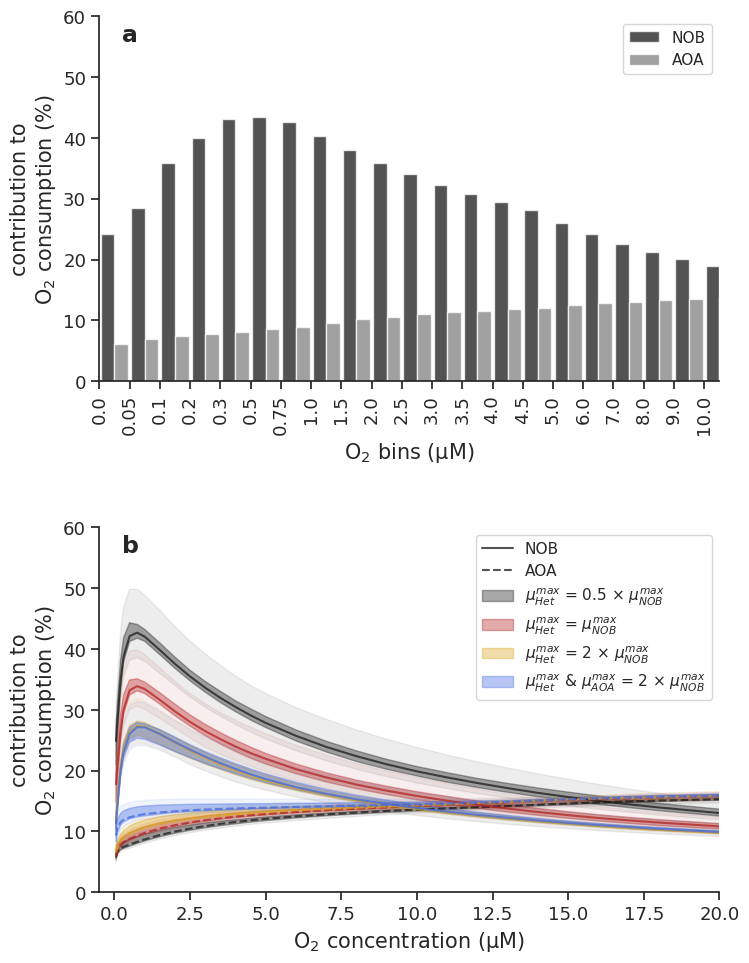

In [24]:

fstic = 13
fslab = 15

cols = ['k', 'firebrick', 'goldenrod', 'royalblue']
lsty = ['-', '--']
alf = 0.75
lwid = [2.0, 2.0]
mar = ['', 'o']
siz = 50

fig = plt.figure(figsize=(8,12))
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(labelsize=fstic)

ax1.bar(np.arange(len(amz_threshold))-0.225, int_o2nob_mean, color=cols[0], width=0.45, alpha=alf, label='NOB')
ax1.bar(np.arange(len(amz_threshold))+0.225, int_o2aoa_mean, color='grey', width=0.45, alpha=alf, label='AOA')
ax1.legend()

ax2.plot(amz_threshold, int_o2nob_q50, color=cols[0], alpha=alf, linestyle=lsty[0], label='NOB')
ax2.plot(amz_threshold, int_o2aoa_q50, color=cols[0], alpha=alf, linestyle=lsty[1], label='AOA')
ax2.fill_between(amz_threshold, int_o2nob_q25, int_o2nob_q75, color=cols[0], alpha=alf*0.5, label=r'$\mu^{max}_{Het}$ = 0.5 $\times$ $\mu^{max}_{NOB}$')
ax2.fill_between(amz_threshold, int_o2aoa_q25, int_o2aoa_q75, color=cols[0], alpha=alf*0.5)
ax2.fill_between(amz_threshold, int_o2nob_q01, int_o2nob_q99, color=cols[0], alpha=alf*0.1)
ax2.fill_between(amz_threshold, int_o2aoa_q01, int_o2aoa_q99, color=cols[0], alpha=alf*0.1)

ax2.plot(amz_threshold, het2_o2nob_q50, color=cols[1], alpha=alf, linestyle=lsty[0])
ax2.plot(amz_threshold, het2_o2aoa_q50, color=cols[1], alpha=alf, linestyle=lsty[1])
ax2.fill_between(amz_threshold, het2_o2nob_q25, het2_o2nob_q75, color=cols[1], alpha=alf*0.5, label=r'$\mu^{max}_{Het}$ = $\mu^{max}_{NOB}$')
ax2.fill_between(amz_threshold, het2_o2aoa_q25, het2_o2aoa_q75, color=cols[1], alpha=alf*0.5)
ax2.fill_between(amz_threshold, het2_o2nob_q01, het2_o2nob_q99, color=cols[1], alpha=alf*0.1)
ax2.fill_between(amz_threshold, het2_o2aoa_q01, het2_o2aoa_q99, color=cols[1], alpha=alf*0.1)

ax2.plot(amz_threshold, nob1_o2nob_q50, color=cols[2], alpha=alf, linestyle=lsty[0])
ax2.plot(amz_threshold, nob1_o2aoa_q50, color=cols[2], alpha=alf, linestyle=lsty[1])
ax2.fill_between(amz_threshold, nob1_o2nob_q25, nob1_o2nob_q75, color=cols[2], alpha=alf*0.5, label=r'$\mu^{max}_{Het}$ = 2 $\times$ $\mu^{max}_{NOB}$')
ax2.fill_between(amz_threshold, nob1_o2aoa_q25, nob1_o2aoa_q75, color=cols[2], alpha=alf*0.5)
ax2.fill_between(amz_threshold, nob1_o2nob_q01, nob1_o2nob_q99, color=cols[2], alpha=alf*0.1)
ax2.fill_between(amz_threshold, nob1_o2aoa_q01, nob1_o2aoa_q99, color=cols[2], alpha=alf*0.1)

ax2.plot(amz_threshold, all_o2nob_q50, color=cols[3], alpha=alf, linestyle=lsty[0])
ax2.plot(amz_threshold, all_o2aoa_q50, color=cols[3], alpha=alf, linestyle=lsty[1])
ax2.fill_between(amz_threshold, all_o2nob_q25, all_o2nob_q75, color=cols[3], alpha=alf*0.5, label=r'$\mu^{max}_{Het}$ & $\mu^{max}_{AOA}$ = 2 $\times$ $\mu^{max}_{NOB}$')
ax2.fill_between(amz_threshold, all_o2aoa_q25, all_o2aoa_q75, color=cols[3], alpha=alf*0.5)
ax2.fill_between(amz_threshold, all_o2nob_q01, all_o2nob_q99, color=cols[3], alpha=alf*0.1)
ax2.fill_between(amz_threshold, all_o2aoa_q01, all_o2aoa_q99, color=cols[3], alpha=alf*0.1)

ax2.legend()


ax1.set_ylim(0,60)
ax1.set_xticks(np.arange(len(amz_threshold)+1)-0.5, np.concatenate((np.array([0.0]), amz_threshold)), rotation=90)
ax1.set_xlim(-0.5,20)
ax1.set_ylabel('contribution to\nO$_2$ consumption (%)', fontsize=fslab)
ax1.set_xlabel('O$_2$ bins (µM)', fontsize=fslab)

ax2.set_ylim(0,60)
ax2.set_xlim(-0.5,20)
#ax2.set_xticks(np.arange(len(amz_threshold)+1)-0.5, np.concatenate((np.array([0.0]), amz_threshold)), rotation=90)
ax2.set_ylabel('contribution to\nO$_2$ consumption (%)', fontsize=fslab)
ax2.set_xlabel('O$_2$ concentration (µM)', fontsize=fslab)

plt.subplots_adjust(bottom=0.15, hspace=0.4)

plt.text(0.05,0.95, 'a', fontweight='bold', ha='center', va='center', fontsize=fslab+2, transform=ax1.transAxes)
plt.text(0.05,0.95, 'b', fontweight='bold', ha='center', va='center', fontsize=fslab+2, transform=ax2.transAxes)



save figure

In [25]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig9_transparent.png", dpi=300, transparent=True)

# determine the frequency of occurances of NOB contribution to O2 consumption within different O2 bins

In [ ]:
%%time

amz_threshold = np.array([0.05,0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0,7.0,8.0,9.0,10.0,11,12,13,14,15,16,17,18,20,30,40,50,60,70,80,100,125,150,175,200])
#amz_threshold = np.array([0.05,0.1,0.25,0.5,1.0,2.0,3.5,5.0,10.0,200])

norm_o2cons_amz_01 = []
norm_o2cons_amz_05 = []
norm_o2cons_amz_12 = []
norm_o2cons_amz_25 = []
norm_o2cons_amz_50 = []
norm_o2cons_amz_me = []
norm_o2cons_amz_wm = []
norm_o2cons_amz_75 = []
norm_o2cons_amz_88 = []
norm_o2cons_amz_95 = []
norm_o2cons_amz_99 = []
norm_o2nob_amz_01 = []
norm_o2nob_amz_05 = []
norm_o2nob_amz_12 = []
norm_o2nob_amz_25 = []
norm_o2nob_amz_50 = []
norm_o2nob_amz_me = []
norm_o2nob_amz_wm = []
norm_o2nob_amz_75 = []
norm_o2nob_amz_88 = []
norm_o2nob_amz_95 = []
norm_o2nob_amz_99 = []
norm_o2aoa_amz_01 = []
norm_o2aoa_amz_05 = []
norm_o2aoa_amz_12 = []
norm_o2aoa_amz_25 = []
norm_o2aoa_amz_50 = []
norm_o2aoa_amz_me = []
norm_o2aoa_amz_wm = []
norm_o2aoa_amz_75 = []
norm_o2aoa_amz_88 = []
norm_o2aoa_amz_95 = []
norm_o2aoa_amz_99 = []

for ii,amz in enumerate(amz_threshold):
    if ii == 0:
        print("Calculating statistics beneath O2 threshold of %.4f"%(amz))
        o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz, other=np.nan).compute()
        volume = (ds['norm_Hz'].where(ds['norm_O2'] < amz, other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    else:
        amzb = amz_threshold[ii-1]
        print("Calculating statistics between O2 thresholds of %.4f and %.4f"%(amzb, amz))
        o2cons = ds['norm_o2cons'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        nitrox = ds['norm_nitrox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        ammox = ds['norm_ammox'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=np.nan).compute()
        volume = (ds['norm_Hz'].where((ds['norm_O2'] < amz) & (ds['norm_O2'] > amzb), other=0.0) * ds['area']).compute()
        o2nob = nitrox * 12.9/27.8 / o2cons * 100
        o2aoa = ammox * 15.5/11.0 / o2cons * 100
    
    o2cons_01 = o2cons.quantile(0.01)
    o2cons_05 = o2cons.quantile(0.05)
    o2cons_12 = o2cons.quantile(0.12)
    o2cons_25 = o2cons.quantile(0.25)
    o2cons_50 = o2cons.quantile(0.50)
    o2cons_me = o2cons.mean()
    o2cons_wm = o2cons.weighted(volume).mean(skipna=True)
    o2cons_75 = o2cons.quantile(0.75)
    o2cons_88 = o2cons.quantile(0.88)
    o2cons_95 = o2cons.quantile(0.95)
    o2cons_99 = o2cons.quantile(0.99)
    #nitrox_01 = nitrox.quantile(0.01)
    #nitrox_05 = nitrox.quantile(0.05)
    #nitrox_25 = nitrox.quantile(0.25)
    #nitrox_50 = nitrox.quantile(0.50)
    #nitrox_me = nitrox.mean()
    #nitrox_wm = nitrox.weighted(volume).mean(skipna=True)
    #nitrox_75 = nitrox.quantile(0.75)
    #nitrox_95 = nitrox.quantile(0.95)
    #nitrox_99 = nitrox.quantile(0.99)
    #ammox_01 = ammox.quantile(0.01)
    #ammox_05 = ammox.quantile(0.05)
    #ammox_25 = ammox.quantile(0.25)
    #ammox_50 = ammox.quantile(0.50)
    #ammox_me = ammox.mean()
    #ammox_wm = ammox.weighted(volume).mean(skipna=True)
    #ammox_75 = ammox.quantile(0.75)
    #ammox_95 = ammox.quantile(0.95)
    #ammox_99 = ammox.quantile(0.99)
    o2nob_01 = o2nob.quantile(0.01)
    o2nob_05 = o2nob.quantile(0.05)
    o2nob_12 = o2nob.quantile(0.12)
    o2nob_25 = o2nob.quantile(0.25)
    o2nob_50 = o2nob.quantile(0.50)
    o2nob_me = o2nob.mean()
    o2nob_wm = o2nob.weighted(volume).mean(skipna=True)
    o2nob_75 = o2nob.quantile(0.75)
    o2nob_88 = o2nob.quantile(0.88)
    o2nob_95 = o2nob.quantile(0.95)
    o2nob_99 = o2nob.quantile(0.99)
    o2aoa_01 = o2aoa.quantile(0.01)
    o2aoa_05 = o2aoa.quantile(0.05)
    o2aoa_12 = o2aoa.quantile(0.12)
    o2aoa_25 = o2aoa.quantile(0.25)
    o2aoa_50 = o2aoa.quantile(0.50)
    o2aoa_me = o2aoa.mean()
    o2aoa_wm = o2aoa.weighted(volume).mean(skipna=True)
    o2aoa_75 = o2aoa.quantile(0.75)
    o2aoa_88 = o2aoa.quantile(0.88)
    o2aoa_95 = o2aoa.quantile(0.95)
    o2aoa_99 = o2aoa.quantile(0.99)
    
    norm_o2cons_amz_01.append(o2cons_01.values*86400)
    norm_o2cons_amz_05.append(o2cons_05.values*86400)
    norm_o2cons_amz_12.append(o2cons_12.values*86400)
    norm_o2cons_amz_25.append(o2cons_25.values*86400)
    norm_o2cons_amz_50.append(o2cons_50.values*86400)
    norm_o2cons_amz_me.append(o2cons_me.values*86400)
    norm_o2cons_amz_wm.append(o2cons_wm.values*86400)
    norm_o2cons_amz_75.append(o2cons_75.values*86400)
    norm_o2cons_amz_88.append(o2cons_88.values*86400)
    norm_o2cons_amz_95.append(o2cons_95.values*86400)
    norm_o2cons_amz_99.append(o2cons_99.values*86400)
    norm_o2nob_amz_01.append(o2nob_01.values)
    norm_o2nob_amz_05.append(o2nob_05.values)
    norm_o2nob_amz_12.append(o2nob_12.values)
    norm_o2nob_amz_25.append(o2nob_25.values)
    norm_o2nob_amz_50.append(o2nob_50.values)
    norm_o2nob_amz_me.append(o2nob_me.values)
    norm_o2nob_amz_wm.append(o2nob_wm.values)
    norm_o2nob_amz_75.append(o2nob_75.values)
    norm_o2nob_amz_88.append(o2nob_88.values)
    norm_o2nob_amz_95.append(o2nob_95.values)
    norm_o2nob_amz_99.append(o2nob_99.values)
    norm_o2aoa_amz_01.append(o2aoa_01.values)
    norm_o2aoa_amz_05.append(o2aoa_05.values)
    norm_o2aoa_amz_12.append(o2aoa_12.values)
    norm_o2aoa_amz_25.append(o2aoa_25.values)
    norm_o2aoa_amz_50.append(o2aoa_50.values)
    norm_o2aoa_amz_me.append(o2aoa_me.values)
    norm_o2aoa_amz_wm.append(o2aoa_wm.values)
    norm_o2aoa_amz_75.append(o2aoa_75.values)
    norm_o2aoa_amz_88.append(o2aoa_88.values)
    norm_o2aoa_amz_95.append(o2aoa_95.values)
    norm_o2aoa_amz_99.append(o2aoa_99.values)

    print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of NOB O2 consumption =", norm_o2nob_amz_01[ii], norm_o2nob_amz_05[ii], norm_o2nob_amz_25[ii], norm_o2nob_amz_50[ii], norm_o2nob_amz_75[ii], norm_o2nob_amz_95[ii], norm_o2nob_amz_99[ii])
    print("1st, 5th, 25th, 50th, 75th, 95th and 99th percentiles of AOA O2 consumption =", norm_o2aoa_amz_01[ii], norm_o2aoa_amz_05[ii], norm_o2aoa_amz_25[ii], norm_o2aoa_amz_50[ii], norm_o2aoa_amz_75[ii], norm_o2aoa_amz_95[ii], norm_o2aoa_amz_99[ii])
    print("mean and weighted mean of NOB O2 consumption =", norm_o2nob_amz_me[ii], norm_o2nob_amz_wm[ii])
    print("mean and weighted mean of AOA O2 consumption =", norm_o2aoa_amz_me[ii], norm_o2aoa_amz_wm[ii])
    

norm_o2cons_amz_01 = np.array(norm_o2cons_amz_01)
norm_o2cons_amz_05 = np.array(norm_o2cons_amz_05)
norm_o2cons_amz_12 = np.array(norm_o2cons_amz_12)
norm_o2cons_amz_25 = np.array(norm_o2cons_amz_25)
norm_o2cons_amz_50 = np.array(norm_o2cons_amz_50)
norm_o2cons_amz_me = np.array(norm_o2cons_amz_me)
norm_o2cons_amz_wm = np.array(norm_o2cons_amz_wm)
norm_o2cons_amz_75 = np.array(norm_o2cons_amz_75)
norm_o2cons_amz_88 = np.array(norm_o2cons_amz_88)
norm_o2cons_amz_95 = np.array(norm_o2cons_amz_95)
norm_o2cons_amz_99 = np.array(norm_o2cons_amz_99)
norm_o2nob_amz_01 = np.array(norm_o2nob_amz_01)
norm_o2nob_amz_05 = np.array(norm_o2nob_amz_05)
norm_o2nob_amz_12 = np.array(norm_o2nob_amz_12)
norm_o2nob_amz_25 = np.array(norm_o2nob_amz_25)
norm_o2nob_amz_50 = np.array(norm_o2nob_amz_50)
norm_o2nob_amz_me = np.array(norm_o2nob_amz_me)
norm_o2nob_amz_wm = np.array(norm_o2nob_amz_wm)
norm_o2nob_amz_75 = np.array(norm_o2nob_amz_75)
norm_o2nob_amz_88 = np.array(norm_o2nob_amz_88)
norm_o2nob_amz_95 = np.array(norm_o2nob_amz_95)
norm_o2nob_amz_99 = np.array(norm_o2nob_amz_99)
norm_o2aoa_amz_01 = np.array(norm_o2aoa_amz_01)
norm_o2aoa_amz_05 = np.array(norm_o2aoa_amz_05)
norm_o2aoa_amz_12 = np.array(norm_o2aoa_amz_12)
norm_o2aoa_amz_25 = np.array(norm_o2aoa_amz_25)
norm_o2aoa_amz_50 = np.array(norm_o2aoa_amz_50)
norm_o2aoa_amz_me = np.array(norm_o2aoa_amz_me)
norm_o2aoa_amz_wm = np.array(norm_o2aoa_amz_wm)
norm_o2aoa_amz_75 = np.array(norm_o2aoa_amz_75)
norm_o2aoa_amz_88 = np.array(norm_o2aoa_amz_88)
norm_o2aoa_amz_95 = np.array(norm_o2aoa_amz_95)
norm_o2aoa_amz_99 = np.array(norm_o2aoa_amz_99)




# save the integrated and statistics within O2 bounds

In [ ]:
df = pd.DataFrame({
    "O2_bound":amz_threshold,
    "o2cons_1st_percentile":norm_o2cons_amz_01,
    "o2cons_5th_percentile":norm_o2cons_amz_05,
    "o2cons_12th_percentile":norm_o2cons_amz_12,
    "o2cons_25th_percentile":norm_o2cons_amz_25,
    "o2cons_50th_percentile":norm_o2cons_amz_50,
    "o2cons_75th_percentile":norm_o2cons_amz_75,
    "o2cons_88th_percentile":norm_o2cons_amz_88,
    "o2cons_95th_percentile":norm_o2cons_amz_95,
    "o2cons_99th_percentile":norm_o2cons_amz_99,
    "o2cons_mean":norm_o2cons_amz_me,
    "o2cons_weightedmean":norm_o2cons_amz_wm,
    "o2nob_1st_percentile":norm_o2nob_amz_01,
    "o2nob_5th_percentile":norm_o2nob_amz_05,
    "o2nob_12th_percentile":norm_o2nob_amz_12,
    "o2nob_25th_percentile":norm_o2nob_amz_25,
    "o2nob_50th_percentile":norm_o2nob_amz_50,
    "o2nob_75th_percentile":norm_o2nob_amz_75,
    "o2nob_88th_percentile":norm_o2nob_amz_88,
    "o2nob_95th_percentile":norm_o2nob_amz_95,
    "o2nob_99th_percentile":norm_o2nob_amz_99,
    "o2nob_mean":norm_o2nob_amz_me,
    "o2nob_weightedmean":norm_o2nob_amz_wm,
    "o2aoa_1st_percentile":norm_o2aoa_amz_01,
    "o2aoa_5th_percentile":norm_o2aoa_amz_05,
    "o2aoa_12th_percentile":norm_o2aoa_amz_12,
    "o2aoa_25th_percentile":norm_o2aoa_amz_25,
    "o2aoa_50th_percentile":norm_o2aoa_amz_50,
    "o2aoa_75th_percentile":norm_o2aoa_amz_75,
    "o2aoa_88th_percentile":norm_o2aoa_amz_88,
    "o2aoa_95th_percentile":norm_o2aoa_amz_95,
    "o2aoa_99th_percentile":norm_o2aoa_amz_99,
    "o2aoa_mean":norm_o2aoa_amz_me,
    "o2aoa_weightedmean":norm_o2aoa_amz_wm,
})

df.to_excel('/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_spatialstatistics.xlsx', index=False)


# make figure of obs versus model spread

In [16]:
## read in the model data in case you don't want to wait for the above calculation to finish
dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_spatialstatistics.xlsx", engine='openpyxl')

amz_threshold = dat['O2_bound']
norm_o2cons_amz_01 = dat['o2cons_1st_percentile']
norm_o2cons_amz_05 = dat['o2cons_5th_percentile']
norm_o2cons_amz_12 = dat['o2cons_12th_percentile']
norm_o2cons_amz_25 = dat['o2cons_25th_percentile']
norm_o2cons_amz_50 = dat['o2cons_50th_percentile']
norm_o2cons_amz_75 = dat['o2cons_75th_percentile']
norm_o2cons_amz_88 = dat['o2cons_88th_percentile']
norm_o2cons_amz_95 = dat['o2cons_95th_percentile']
norm_o2cons_amz_99 = dat['o2cons_99th_percentile']
norm_o2cons_amx_me = dat['o2cons_mean']
norm_o2cons_amx_wm = dat['o2cons_weightedmean']

norm_o2nob_amz_01 = dat['o2nob_1st_percentile']
norm_o2nob_amz_05 = dat['o2nob_5th_percentile']
norm_o2nob_amz_12 = dat['o2nob_12th_percentile']
norm_o2nob_amz_25 = dat['o2nob_25th_percentile']
norm_o2nob_amz_50 = dat['o2nob_50th_percentile']
norm_o2nob_amz_75 = dat['o2nob_75th_percentile']
norm_o2nob_amz_88 = dat['o2nob_88th_percentile']
norm_o2nob_amz_95 = dat['o2nob_95th_percentile']
norm_o2nob_amz_99 = dat['o2nob_99th_percentile']
norm_o2nob_amx_me = dat['o2nob_mean']
norm_o2nob_amx_wm = dat['o2nob_weightedmean']

norm_o2aoa_amz_01 = dat['o2aoa_1st_percentile']
norm_o2aoa_amz_05 = dat['o2aoa_5th_percentile']
norm_o2aoa_amz_12 = dat['o2aoa_12th_percentile']
norm_o2aoa_amz_25 = dat['o2aoa_25th_percentile']
norm_o2aoa_amz_50 = dat['o2aoa_50th_percentile']
norm_o2aoa_amz_75 = dat['o2aoa_75th_percentile']
norm_o2aoa_amz_88 = dat['o2aoa_88th_percentile']
norm_o2aoa_amz_95 = dat['o2aoa_95th_percentile']
norm_o2aoa_amz_99 = dat['o2aoa_99th_percentile']
norm_o2aoa_amx_me = dat['o2aoa_mean']
norm_o2aoa_amx_wm = dat['o2aoa_weightedmean']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics.xlsx", engine='openpyxl')

int_vol_mean = dat['int_vol_mean']
int_nitrox_mean = dat['int_nitrox_mean']
int_ammox_mean = dat['int_ammox_mean']
int_o2cons_mean = dat['int_o2cons_mean']
int_o2nob_mean = dat['int_o2nob_mean']
int_o2aoa_mean = dat['int_o2aoa_mean']
int_o2nob_std = dat['int_o2nob_std']
int_o2nob_q01 = dat['int_o2nob_q01']
int_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_het2p0.xlsx", engine='openpyxl')

het2_vol_mean = dat['int_vol_mean']
het2_nitrox_mean = dat['int_nitrox_mean']
het2_ammox_mean = dat['int_ammox_mean']
het2_o2cons_mean = dat['int_o2cons_mean']
het2_o2nob_mean = dat['int_o2nob_mean']
het2_o2aoa_mean = dat['int_o2aoa_mean']
het2_o2nob_std = dat['int_o2nob_std']
het2_o2nob_q01 = dat['int_o2nob_q01']
het2_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_nob1p0.xlsx", engine='openpyxl')

nob1_vol_mean = dat['int_vol_mean']
nob1_nitrox_mean = dat['int_nitrox_mean']
nob1_ammox_mean = dat['int_ammox_mean']
nob1_o2cons_mean = dat['int_o2cons_mean']
nob1_o2nob_mean = dat['int_o2nob_mean']
nob1_o2aoa_mean = dat['int_o2aoa_mean']
nob1_o2nob_std = dat['int_o2nob_std']
nob1_o2nob_q01 = dat['int_o2nob_q01']
nob1_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_allmu.xlsx", engine='openpyxl')

all_vol_mean = dat['int_vol_mean']
all_nitrox_mean = dat['int_nitrox_mean']
all_ammox_mean = dat['int_ammox_mean']
all_o2cons_mean = dat['int_o2cons_mean']
all_o2nob_mean = dat['int_o2nob_mean']
all_o2aoa_mean = dat['int_o2aoa_mean']
all_o2nob_std = dat['int_o2nob_std']
all_o2nob_q01 = dat['int_o2nob_q01']
all_o2nob_q99 = dat['int_o2nob_q99']


In [17]:
# get obs
beman = pd.read_excel("/home/pbuchanan/analysis_nox/Beman2021_O2consumption.xlsx", engine='openpyxl')
beman


,O2,Nox_consump
0,0.720000,56.290171
1,1.329231,68.671150
2,1.458462,47.194122
3,0.720000,37.792409
4,0.572308,20.074151
5,0.203077,20.078976
6,0.387692,15.882110
7,0.646154,15.694449
8,2.086154,13.783493
9,1.329231,10.168521


In [13]:
# count how many fall within the different bounds of the model

count_in_00_01 = 0
count_in_01_05 = 0
count_in_05_12 = 0
count_in_12_25 = 0
count_in_25_50 = 0
count_in_50_75 = 0
count_in_75_88 = 0
count_in_88_95 = 0
count_in_95_99 = 0
count_in_99_100 = 0

for ii,ox in enumerate(amz_threshold):
    if ii == 0:
        continue
    tmp = beman[beman['O2'] < ox]
    tmp = tmp[tmp['O2'] > amz_threshold[ii-1]]
    if len(tmp) == 0.0:
        continue
    else:
        for nox in tmp['Nox_consump']:
            #print(ii, ox, nox)
    
            if nox < norm_o2nob_amz_01[ii]:
                count_in_00_01 += 1
            if nox >= norm_o2nob_amz_01[ii] and nox < norm_o2nob_amz_05[ii]:
                count_in_01_05 += 1
            if nox >= norm_o2nob_amz_05[ii] and nox < norm_o2nob_amz_12[ii]:
                count_in_05_12 += 1
            if nox >= norm_o2nob_amz_12[ii] and nox < norm_o2nob_amz_25[ii]:
                count_in_12_25 += 1
            if nox >= norm_o2nob_amz_25[ii] and nox < norm_o2nob_amz_50[ii]:
                count_in_25_50 += 1
            if nox >= norm_o2nob_amz_50[ii] and nox < norm_o2nob_amz_75[ii]:
                count_in_50_75 += 1
            if nox >= norm_o2nob_amz_75[ii] and nox < norm_o2nob_amz_88[ii]:
                count_in_75_88 += 1
            if nox >= norm_o2nob_amz_88[ii] and nox < norm_o2nob_amz_95[ii]:
                count_in_88_95 += 1
            if nox >= norm_o2nob_amz_95[ii] and nox < norm_o2nob_amz_99[ii]:
                count_in_95_99 += 1
            if nox >= norm_o2nob_amz_99[ii]:
                count_in_99_100 += 1


count_obs_in_model_range = np.array([count_in_00_01, count_in_01_05, count_in_05_12, count_in_12_25, count_in_25_50, count_in_50_75, count_in_75_88, count_in_88_95, count_in_95_99, count_in_99_100])


Text(0.5, 0, 'quantiles of model (%)')

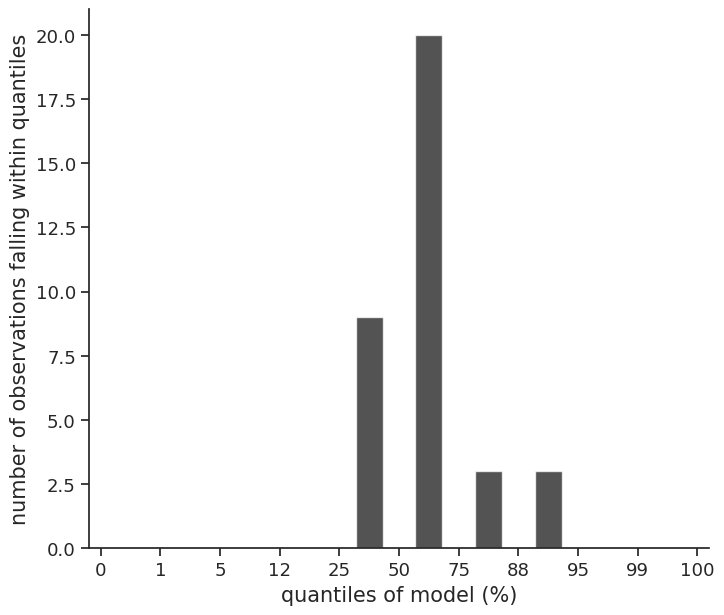

In [14]:
fstic = 13
fslab = 15

cols = ['k', 'grey']
lsty = ['-', '-']
alf = 0.75
lwid = [2.0, 2.0]
mar = ['', 'o']
siz = 50

fig = plt.figure(figsize=(8,7))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0])

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(labelsize=fstic)

ax1.bar(np.arange(len(count_obs_in_model_range))-0.5, count_obs_in_model_range, color=cols[0], width=0.45, alpha=alf)

xlabs = np.array([0, 1, 5, 12, 25, 50, 75, 88, 95, 99, 100])

ax1.set_ylim(0,21)
ax1.set_xticks(np.arange(len(count_obs_in_model_range)+1)-1, xlabs)
ax1.set_ylabel('number of observations falling within quantiles', fontsize=fslab)
ax1.set_xlabel('quantiles of model (%)', fontsize=fslab)
#plt.subplots_adjust(bottom=0.15, hspace=0.4)


In [49]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig10-obscount_transparent.png", dpi=300, transparent=True)
